# La costruzione, l’addestramento, e il funzionamento di una semplice rete neurale per comprimere immagini

Luca Mari, novembre 2024  

Quest'opera è distribuita con <a href="http://creativecommons.org/licenses/by-nc-sa/4.0" target="_blank">Licenza Creative Commons Attribuzione - Non commerciale - Condividi allo stesso modo 4.0 Internazionale</a>.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

**Obiettivo**: a partire da un esempio concreto, comprendere la logica del funzionamento di un _autoencoder_, una semplice rete neurale immpiegata qui per fare compressione di immagini.  
**Precompetenze**: basi di Python.

> Per eseguire questo notebook con VSCode sul proprio calcolatore, occorre:
> * installare un interprete Python
> * scaricare da https://code.visualstudio.com/download e installare VSCode
> * eseguire VSCode e attivare le estensioni per Python e Jupyter
> * ancora in VSCode:
>     * creare una cartella di lavoro e renderla la cartella corrente
>     * copiare nella cartella il file di questa attività: [autoencoder.ipynb](autoencoder.ipynb)
>     * aprire il notebook `autoencoder.ipynb`
>     * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
>     * installare i moduli Python richiesti, eseguendo dal terminale:  
>         `pip install torch torchvision numpy matplotlib`

La rete che costruiremo ha lo scopo, apparentemente inutile, di realizzare una funzione identità: generare un output che sia uguale all'input ricevuto. Questo comportamento è invece interessante perché la rete opera come un sistema di compressione di dati: in riferimento al [dataset MNIST](https://en.wikipedia.org/wiki/MNIST_database), che contiene immagini di cifre scritte a mano, ogni immagine è una matrice di 28x28 punti in cui a ogni punto è associato un colore nella scala dei grigi, e quindi l'input è un'immagine di 28x28 = 768 bytes (più precisamente, per ragioni di normalizzazione ogni valore tra 0 e 255 è diviso per 255, e perciò in input al codificatore ci sono vettori di float tra 0 e 1).  
Nel corso del suo addestramento, la rete dovrebbe imparare a riconoscere le strutture presenti nelle immagini, in modo che in uscita dalla sua prima parte -- il _codificatore_ (_encoder_) -- l'informazione su un'immagine sia mantenuta in (per esempio) 32 neuroni, sufficienti perché in uscita dalla seconda parte della rete -- il _decodificatore_ (_decoder_) -- l'immagine possa essere rigenerata con una qualità sufficiente. Nel suo complesso, una rete di questo genere si chiama _autocodificatore_ (_autoencoder_).

Dopo aver importato i moduli Python necessari, carichiamo le immagini del training set (la prima volta i file con le immagini saranno scaricati dal web e copiati in una cartella locale).

In [30]:
import torch
from torch import nn
import torch.utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

training_set = datasets.MNIST(root="data",              # 60000 immagini, ognuna di 28x28 pixel
                         train=True,                    # training set
                         download=True,
                         transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                     batch_size=32,     # se ogni batch ha 32 immagini, ci sono 60000/32 = 1875 batch
                                     shuffle=True)

Un dettaglio tecnico: mostriamo come funziona il loader.

Ogni batch ha questa struttura:
immagini: torch.Size([32, 1, 28, 28]); etichette: torch.Size([32])

La prima immagine del batch ha come etichetta 5 ed è:


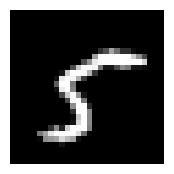

In [31]:
images, labels = next(iter(train_loader))               # il loader è un iteratore; prendendo il suo primo elemento, si ottiene il primo batch...
print(f'Ogni batch ha questa struttura:\nimmagini: {images.shape}; etichette: {labels.shape}') # ... di 32 immagini e 32 etichette

print(f'\nLa prima immagine del batch ha come etichetta {labels[0].item()} ed è:')

plt.figure(figsize=(2, 2))
plt.imshow(images[0][0].numpy(), cmap="gray")
plt.axis("off")
plt.show()

Costruiamo e instanziamo la rete, e definiamo quindi la funzione di errore e la funzione di ottimizzazione per il suo addestramento.

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
         
        self.decoder = torch.nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x, mode='encoder_decoder'):       # il parametro 'mode' consente di specificare come usare la rete 
        if mode != 'decoder_only': x = self.encoder(x)
        if mode != 'encoder_only': x = self.decoder(x)
        return x

model = Autoencoder()

num_MLP_params = sum(p.numel() for p in model.parameters())
print(f"Questa è dunque una rete con {num_MLP_params} parametri.")

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

Questa è dunque una rete con 222384 parametri.


Per addestrare la rete occorre far lavorare insieme il codificatore e il decodificatore, in modo da far sì che il secondo impari a operare in funzione del primo (come si vede sotto, la funzione di errore converge rapidamente, e quindi sono sufficienti poche epoche).

Epoche:  1 2 3 4 5 

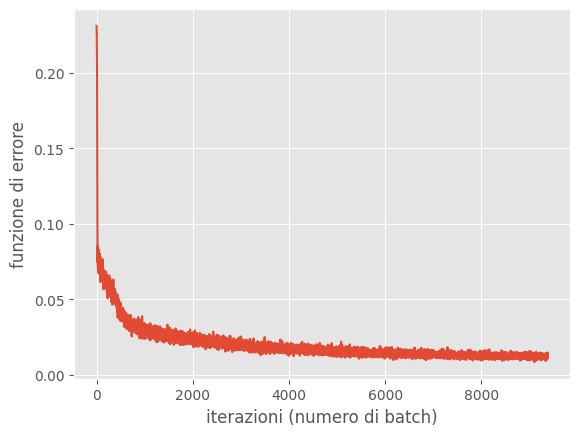

In [33]:
epochs = 5
losses = []
outcomes = []
i = 0
print('Epoche: ', end=" ")
for epoch in range(epochs):                             # per ogni epoca
    for (images, _) in train_loader:                    # per ognuno dei 1875 batch
        images = images.reshape(-1, 28*28)              # considera in parallelo ognuna delle 32 immagini del batch
        reconstructed = model(images)                   # e applica il modello, cioè ricostruiscila comprimendola e poi decomprimendola

        loss = loss_function(reconstructed, images)     # calcola la funzione di errore tra l'immagine originale e quella ricostruita
        optimizer.zero_grad()                           # azzera i gradienti del modello
        loss.backward()                                 # calcola i gradienti della funzione di errore rispetto ai parametri del modello
        optimizer.step()                                # aggiorna i parametri del modello in base ai gradienti calcolati

        losses.append(loss.item())                      # salva il valore della funzione di errore per ogni batch dell'epoca
    
    outcomes.append((epoch, images, reconstructed))     # per ogni epoca, salva le immagini originali e le immagini ricostruite dell'ultimo batch
    print(1+epoch, end=" ")

plt.style.use('ggplot')
plt.xlabel('iterazioni (numero di batch)')
plt.ylabel('funzione di errore')
plt.plot(losses)
plt.show()

Vediamo gli effetti dell'addestramento scegliendo in modo casuale un'immagine dell'ultimo batch dell'ultima epoca di addestramento e visualizzandola insieme con la sua versione ricostruita, cioè compressa e poi decompressa.

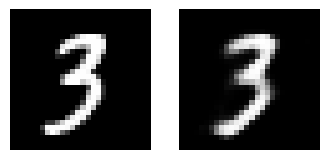

In [34]:
epoch = epochs - 1                                      # ultima epoca
n = random.randint(0, 31)                               # scegli una delle 32 immagini del batch
input = outcomes[epoch][1][n].reshape(28, 28).detach().numpy()
output = outcomes[epoch][2][n].reshape(28, 28).detach().numpy()
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(input, cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(output, cmap="gray")
plt.axis("off")
plt.show()

Mettiamo ora alla prova la qualità dell'autoencoder come sistema di compressione di dati operando su un batch di immagini diverse da quelle usate nell'addestramento.

In [119]:
testset = datasets.MNIST(root="data",
                         train=False,                       # test set
                         download=True,
                         transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=testset,
                                     batch_size=32,
                                     shuffle=True)

images, _ = next(iter(test_loader))
images = images.reshape(-1, 28*28)

Scegliamo in modo casuale un'immagine dal batch e visualizziamola insieme con la sua versione ricostruita.

Un'immagine, inizialmente mantenuta in un vettore di 784 byte,
è stata compressa in un vettore di 32 numeri, ognuno di 2 byte,
per un totale di 64 byte, dunque con un rapporto di compressione di 784/64 = 12.25.


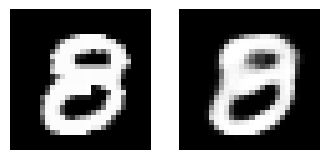

In [123]:
encoded = model(images, mode='encoder_only')                # codifica le immagini
encoded16 = encoded.detach().numpy().astype('float16')      # trasforma in un vettore di numeri a 16 bit

print(f"Un'immagine, inizialmente mantenuta in un vettore di {28*28} byte,")
print(f"è stata compressa in un vettore di {encoded16.shape[1]} numeri, ognuno di 2 byte,")
print(f"per un totale di {encoded16.shape[1]*2} byte, dunque con un rapporto di compressione di {28*28}/{encoded16.shape[1]*2} = {(28*28)/(encoded16.shape[1]*2)}.")

to_decode = torch.tensor(encoded16, dtype=torch.float32)    # trasforma encoded16 in un tensore con i tipi di dati corretti
decoded = model(to_decode, mode='decoder_only')             # e quindi decodifica le immagini

n = random.randint(0, 31)
input = images[n].reshape(28, 28).detach().numpy()
output = decoded[n].reshape(28, 28).detach().numpy()
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(input, cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(output, cmap="gray")
plt.axis("off")
plt.show()

Se diamo ora in input al decodificatore addestrato dei vettori di numeri casuali, osserviamo un interessante comportamento: la rete cerca di interpretarli come se fossero la versione compressa di immagini analoghe a quelle con cui era stata addestrata, ma ovviamente -- e correttamente -- non produce immagini che siano riconoscibili come numeri.

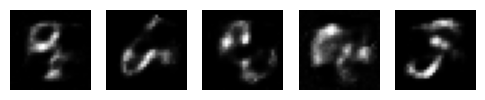

In [37]:
import numpy as np

random_array = np.random.normal(0, 3, (5, 32)).astype('float16') # array di 10 x 32 float a 16 bit da una gaussiana con media 0 e deviazione standard 3

to_decode = torch.tensor(random_array, dtype=torch.float32) # trasforma l'array in un tensore con i tipi di dati corretti
decoded = model(to_decode, mode='decoder_only')             # e quindi decodifica le 10 immagini

plt.figure(figsize=(6, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(decoded[i].reshape(28, 28).detach().numpy(), cmap="gray")
    plt.axis("off")
plt.show()

Mettiamo ulteriormente alla prova il comportamento dell'autoencoder operando su un batch di immagini diverse da quelle usate nell'addestramento, perché questa volta non di cifre numeriche ma di lettere dell'alfabeto.

In [147]:
emnist_dataset = datasets.EMNIST(root='data', split='letters', download=True, train=True, transform=transforms.ToTensor())

emnist_loader = torch.utils.data.DataLoader(dataset=emnist_dataset,
                                        batch_size=32,
                                        shuffle=True)

images, _ = next(iter(emnist_loader))
images = images.reshape(-1, 28*28)

Scegliamo in modo casuale un'immagine dal batch e visualizziamola insieme con la sua versione ricostruita.

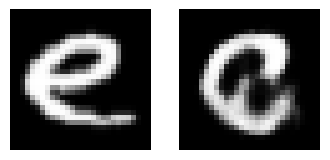

In [161]:
encoded = model(images, mode='encoder_only')                # codifica le immagini
encoded16 = encoded.detach().numpy().astype('float16')      # trasforma in un vettore di numeri a 16 bit

to_decode = torch.tensor(encoded16, dtype=torch.float32)    # trasforma encoded16 in un tensore con i tipi di dati corretti
decoded = model(to_decode, mode='decoder_only')             # e quindi decodifica le immagini

n = random.randint(0, 31)
input = images[n].reshape(28, 28)
input = torch.rot90(input, 1, [0, 1]).flip(0).detach().numpy() # le immagini delle lettere sono da ruotare e capovolgere

output = decoded[n].reshape(28, 28)
output = torch.rot90(output, 1, [0, 1]).flip(0).detach().numpy()

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(input, cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(output, cmap="gray")
plt.axis("off")
plt.show()